# Imports

In [1]:
%matplotlib ipympl

import itertools
import math
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import scipy.interpolate
import scipy.optimize
import skimage.measure
from tqdm import tqdm

# Helper Functions

In [2]:
# Gamma (0)
# (0,0)
# first shell (1, 6), -1 to +1
# (1,0), (0,1), (-1,1), (-1,0), (0, -1), (1, -1)
# second shell (7, 12) -2 to 2
# (1,1), (-1, 2), (-2, 1), (-1, -1), (1, -2), (2, -1)
# third shell (12, 18) -2 to 2
# (2, 0), (0, 2), (-2, 2), (-2, 0), (0, -2), (2, -2)
# fourth shell (19, 30) -3 to 3
# (2, 1), (1, 2), (3, -1), (3, -2), (-3, 2), (-3, 1), (-2, -1), (-1, -2), (-3, 1), (-3, 2), (3, -2), (3, -1)
# fifth shell (31, 36) -3 to 3
# (3, 0), (0, 3), (-3, 3), (-3, 0), (0, -3), (3, -3)

In [3]:
def get_len(mn):
    """
    Returns the length of a reciprocal lattice vector, in units of 1/am

    Args:
        mn: Can be a list/tuple/array of 2 integers or floats, or an array of shape (2, N)
    Returns:
        float | np.ndarray[float]: length(s) of the reciprocal lattice vector(s), float or array of shape (N,)
    """
    m, n = mn
    return np.hypot( 4*np.pi/np.sqrt(3) * (m + n/2), 2*np.pi*n)

def get_angle(mn: tuple[int, int]) -> float:
    """
    Returns the angle between a reciprocal lattice vector and the positive x-axis, between -pi/2 and pi/2

    Args:
        mn: Can be a list/tuple/array of 2 integers or floats, or an array of shape (2, N)
    Returns:
        float | np.ndarray[float]: angle(s) of reciprocal lattice vector(s), float or array of shape (N,)
    """
    m, n = mn
    return np.arctan2(2*np.pi*n, 4*np.pi/np.sqrt(3) * (m + n/2))

def get_coords(mn):
    """
    Returns the coordinates of a reciprocal lattice vector, in units of 1/am

    Args:
        mn: Can be a list/tuple/array of 2 integers, or an array of shape (2, N)
    Returns:
        np.ndarray[float]: coordinates of the reciprocal lattice vector(s), shape (2, N)
    """
    m, n = mn
    return np.array([4*np.pi/np.sqrt(3) * (m + n/2), 2*np.pi*n])

def get_mn(k):
    """
    Converts a k-point (in units of 1/am) to its 
    m*G_1 + n*G_2

    Returns:
        np.ndarray[float]: shape (2, N)
    """
    kx, ky = k
    n = ky/2/np.pi
    m = np.sqrt(3)*kx/4/np.pi - n/2
    return np.array([m, n])

def get_len_angle(mn):
    return get_len(mn), get_angle(mn)


# these act in the coordinate basis
def rot60(i: int | float) -> np.ndarray:
    """
    Returns a rotation matrix R representing a rotation by 60*i degrees. Acts in the coordinate basis.
    """
    c = np.cos(i*np.pi/3)
    s = np.sin(i*np.pi/3)
    return np.array([[c, -s],[s, c]])

def mirrorX() -> np.ndarray:
    """
    Returns a mirror matrix Sz that flips the y-coordinate of a point. Acts in the coordinate basis
    """
    return np.array([[1,0],[0,-1]])

In [4]:
# k is in units of 1/a
def g(i: int) -> np.ndarray:
    """
    Gets the ith reciprocal lattice vector. RLVs are sorted by distance from the origin, then by angle.
    """
    prev_shell = g.__dict__.get('shell', 0)
    shell = math.ceil(i / 6)
    max_n = 1 + shell//2
    g.__dict__['shell'] = shell
    prev_sorted = g.__dict__.get('sorted_gmn', [])
    
    if shell <= prev_shell and len(prev_sorted):
        return np.array(prev_sorted[i])
    else:
        # make a bunch of points
        gmn = list(itertools.product(range(-max_n, max_n+1), range(-max_n, max_n+1)))
        sorted_gmn = sorted(gmn, key=get_len_angle)
        g.__dict__['sorted_gmn'] = sorted_gmn
        return np.array(sorted_gmn[i])

In [5]:
g_odd = (g(1), g(3), g(5))
g_even = (g(2), g(4), g(6))

def hkmel(k, g_vec, g_prime, theta=2, mstar=1.2):
    """
    Returns the layer-Hamiltonian matrix element: <g + k| H |g' + k>.
    Uses parameters from Pan, Kim and Jiang (2023) Phys. Rev. Research https://doi.org/10.1103/PhysRevResearch.5.043173
    All energies are in units of meV.

    Arguments:
        k (np.ndarray): k point to compute the Hamiltonian at. In reciprocal lattice-basis, shape (2,)
        g_vec (np.ndarray): Reciprocal lattice vector g. In reciprocal lattice-basis, shape (2,)
        g_prime (np.ndarray): Reciprocal lattice vector g'. In reciprocal lattice-basis, shape (2,)
        theta (float): Optional. Twist angle (in degrees) between the two bilayers. Default 2.
        mstar (float): Optional. Effective mass of Gamma valley carriers in the pristine bilayer. Default 1.2.
    Returns:
        np.ndarray[float]: Matrix-element (still a matrix in the layer basis).
    """
    hbarsqover2mstar = 7620/2/mstar

    V1 = 200
    V20 = -159
    V21 = -8
    phi = -0.17
    V12 = 184
    V230 = 356
    V231 = -9
    theta_r = theta*np.pi/180
    am = 3.28/theta_r
    
    res = np.zeros((4,4), dtype=np.complex128)
    if np.all(g_vec == g_prime):
        res -= hbarsqover2mstar * (get_len(k + g_vec)/am)**2 * np.eye(4)
        res += np.array([[V1,  V12,  0,    0  ],
                         [V12, V20,  V230, 0. ],
                         [0,   V230, V20,  V12],
                         [0,   0,    V12,  V1 ]])
    for gj in g_odd:
        if np.all(gj == g_vec-g_prime):
            res += np.array([[0, 0,                  0,                   0],
                             [0, V21*np.exp(1j*phi), V231,                0],
                             [0, V231,               V21*np.exp(-1j*phi), 0],
                             [0, 0,                  0,                   0]])
    for gj in g_even:
        if np.all(gj == g_vec-g_prime):
            res += np.array([[0, 0,                   0,                  0],
                             [0, V21*np.exp(-1j*phi), V231,               0],
                             [0, V231,                V21*np.exp(1j*phi), 0],
                             [0, 0,                   0,                  0]])
    return res

In [6]:
g(4)/3 + g(3)/3

array([0.33333333, 0.33333333])

In [7]:
def get_grid(m: int, get_weights=False) -> np.ndarray:
    """
    Returns a Monkhorst-Pack grid of points over the hexagonal Irreducible Brillouin Zone

    Arguments:
        m (int): Controls grid spacing. There are m+1 points on the grid between gamma and m (inclusive).
        get_weights (bool): Whether or not to return an array of weights corresponding to how many times
            a point in the IBZ appears in the full BZ. E.g. the gamma point has weight 1, points along
            gamma to m and gamma to k have weight 6, and points in the interior of the IBZ have weight 12.
            Default is False.
    
    Returns:
        np.ndarray: array of points, shape is (N,2), where N = 1 + m + int(m**2 / 3)
        np.ndarray: (optional) array of weights, shape is (N,)
    """
    
    n1 = (np.arange(m+1))/m/2
    n2 = (np.arange(m+1))/m/2
    
    grid = []
    weights = []
    c = 0
    for i in range(len(n1)):
        for j in range(len(n2)):
            if get_coords(n1[i]*g(3) + n2[j]*g(4))[0] > get_coords(n1[-1]*g(3))[0]:
                pass
            else:
                if n2[j] > n1[i]:
                    pass
                else:
                    grid.append(n1[i]*g(3) + n2[j]*g(4))
                    if n1[i] == n2[j]:
                        if n1[i] == 0:
                            weights.append(1)
                        else:
                            weights.append(6)
                    elif n2[j] == 0:
                        weights.append(6)
                    else:
                        weights.append(12)
    if get_weights:
        return np.array(grid), np.array(weights)
    else:
        return np.array(grid)

In [8]:
def build_Hk(k: np.ndarray, g_basis: np.ndarray, theta: float, mstar: float):
    """
    Returns H(k) in plane wave basis.

    Arguments:
        k (np.ndarray): k point at which to evaluate the Hamiltonian (in reciprocal lattice basis). Shape is (2,)
        g_basis (np.ndarray): set of G vectors to expand Hamiltonian in (in reciprocal lattice basis). Shape is (N,2)
        theta (float): twist angle (in degrees)
        mstar (float): bilayer hole effective mass (in units of m_e)
    Returns:
        np.ndarray: H(k) in plane wave, layer basis. Shape is (4N,4N)
    """
    h = []
    for i, g_vec in enumerate(g_basis):
        h.append([])
        for j, g_prime in enumerate(g_basis):
            h[i].append(hkmel(k, g_vec, g_prime, theta=theta, mstar=mstar))
    return np.block(h)

# Convergence Testing

100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.49it/s]


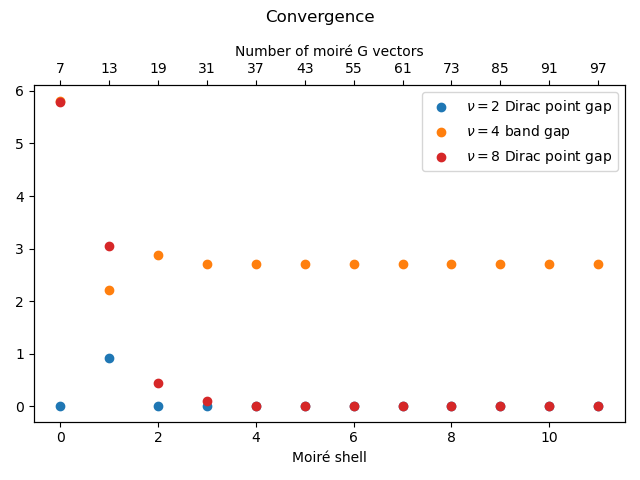

In [9]:
theta = 2.4
mstar = 1.0

# check for convergence
shell_boundaries = 1 + np.where(np.diff([get_len(g(i)) for i in range(100)]) > 1e-3)[0][1:]
fig, ax = plt.subplots()
theta = 2.5
mstar = 1.2
for shell, shell_n in enumerate(tqdm(shell_boundaries)):
    g_basis = [g(i) for i in range(shell_n)]
    Hk = build_Hk(np.array([1/3,1/3]), g_basis, theta=theta, mstar=mstar)
    eig = np.linalg.eigh(Hk)
    k_bands = eig.eigenvalues
    gap_12_k = k_bands[-1] - k_bands[-2]
    gap_45_k = k_bands[-4] - k_bands[-5]

    Hk = build_Hk(np.array([0,0]), g_basis, theta=theta, mstar=mstar)
    eig = np.linalg.eigh(Hk)
    g_bands = eig.eigenvalues

    gap_23 = g_bands[-2] - k_bands[-3]
    
    ax.scatter(shell, gap_12_k, c="C0")
    ax.scatter(shell, gap_23, c="C1")
    ax.scatter(shell, gap_45_k, c="C3")
plt.legend([r'$\nu=2$ Dirac point gap', r'$\nu=4$ band gap', r'$\nu=8$ Dirac point gap'])
# plt.yscale('log')
ax.set_xlabel("Moiré shell")
ax2 = ax.twiny()
ax2.set_xlabel("Number of moiré G vectors")
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(range(shell+1))
ax2.set_xticklabels([f"{shell_n}" for shell_n in shell_boundaries])

fig.suptitle("Convergence")
plt.tight_layout()
plt.show()

# $\Gamma K M \Gamma$ Band Structure

In [10]:
# High-symmetry points in the IBZ, K, M, Γ, in reciprocal lattice vector basis
k_k = g(4)/3 + g(3)/3
k_m = g(3)/2
k_g = g(0)

# this ratio of points between Γ-M, Γ-K, M-K gives roughly equal spacing
points = 21
points_m_k = points * 3
points_g_m = points * 6
points_g_k = points * 7

path_g_k = (k_k[np.newaxis, ...] / points_g_k * np.arange(points_g_k)[...,np.newaxis])
path_k_m = k_k + (k_m - k_k)[np.newaxis, ...] / points_m_k * np.arange(points_m_k)[...,np.newaxis]
path_m_g = k_m[np.newaxis, ...] / points_g_m * np.arange(points_g_m, -1, -1)[...,np.newaxis]

k_path = np.concatenate([path_g_k, path_k_m, path_m_g])
if np.__version__ >= '2':
    k_path_dist = np.cumulative_sum(get_len(np.diff(k_path, axis=0).T), include_initial=True)
else:
    k_path_dist = np.cumsum(get_len(np.diff(k_path, axis=0, prepend=0).T))

# generate list of G vectors as basis to expand Hamiltonian in.
# By using 73 G vectors, we expand to the 9th shell of moiré RL points.
g_basis = [g(i) for i in range(73)]

gkmg_bands = np.zeros((len(k_path), len(g_basis)*4))
gkmg_psi = np.zeros((len(k_path), len(g_basis)*4, len(g_basis)*4), dtype=np.complex128)

# at each k-point along our path, we expand the Hamiltonian at that point in the moiré G vector basis
theta = 2.5
mstar = 1.2
for n, k in enumerate(tqdm(k_path)):
    Hk = build_Hk(k, g_basis, theta=theta, mstar=mstar)
    eig = np.linalg.eigh(Hk)
    
    gkmg_bands[n] = eig.eigenvalues
    gkmg_psi[n] = eig.eigenvectors

100%|█████████████████████████████████████████| 337/337 [00:45<00:00,  7.45it/s]


5.208146762578281


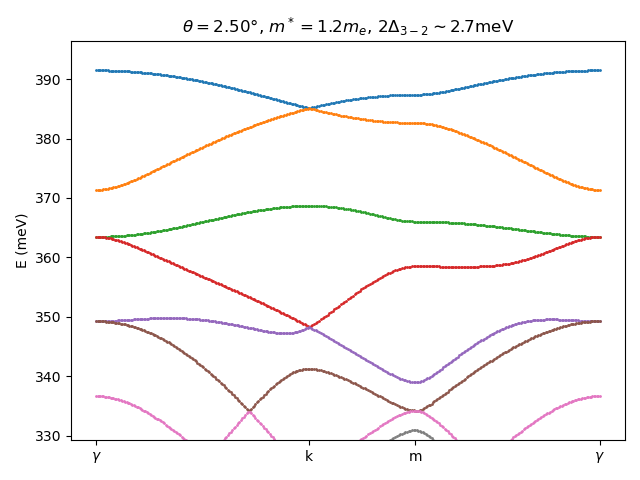

In [11]:
plt.figure()
for i in range(len(g_basis)*4-1,-1,-1):
    plt.scatter(k_path_dist, gkmg_bands[:,i], 1)

VBM = np.max(gkmg_bands[:,-1])
p_honeycomb_min = np.min(gkmg_bands[:,-6])

gap_3_2 = np.min(gkmg_bands[:,-2]) - np.max(gkmg_bands[:,-3])

band_3_bw = np.max(gkmg_bands[:,-3]) - np.min(gkmg_bands[:,-3])
print(band_3_bw)

plt.ylim(p_honeycomb_min - 5, VBM + 5)
plt.title(rf"$\theta={theta:.2f}\degree$, $m^* = {mstar:.1f} m_e$, "+r"$2\Delta_{3-2} \sim$" + rf"${gap_3_2:.1f}$" + r"$\text{meV}$")
plt.ylabel("E (meV)")

plt.xticks([0, k_path_dist[points_g_k], k_path_dist[points_g_k+points_m_k], k_path_dist[-1]], [r"$\gamma$", "k", "m",r"$\gamma$"])
plt.tight_layout()
# plt.savefig(f"ABBA_BS_{theta:.2f}_deg_{mstar:.1f}me.png", dpi=600, transparent=True)
plt.show()

## Wavefunction Plotting

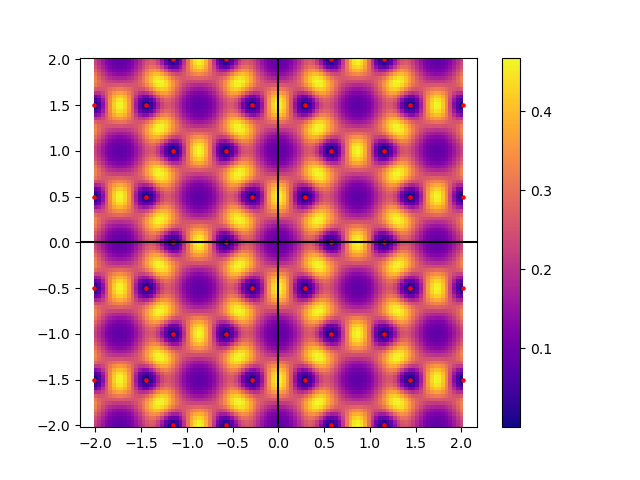

In [12]:
# indices of high-symmetry points in k_path
g_ix = 0
k_ix = points_g_k
m_ix = points_g_k + points_m_k

Gs = np.array([get_coords(g_i) for g_i in g_basis])
g_vec = get_coords(k_path[g_ix])
k_vec = get_coords(k_path[k_ix])
m_vec = get_coords(k_path[m_ix])

plt.figure()
# make meshgrids of x and y (in units of am)
x, y = np.meshgrid(np.linspace(-np.sqrt(3)/2, np.sqrt(3)/2, 100), np.linspace(-1, 1, 100))
x, y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
r = np.moveaxis(np.array([x, y]), 0, 2)

# indices are k, G, layer, band
gkmg_psi_layer = gkmg_psi.reshape(len(k_path), len(g_basis), 4, 4*len(g_basis))

psi = np.zeros((*x.shape, 4), dtype=np.complex128)

band = 3
for i, g_i in enumerate(Gs):
    psi += gkmg_psi_layer[k_ix,i,:,-band][np.newaxis, np.newaxis,...] * np.exp(1j*(r @ (g_i + k_vec)))[...,np.newaxis]

layer = 0
plt.pcolormesh(
    x,
    y,
    np.abs(psi[...,layer])**2,
    cmap='plasma'
)
plt.colorbar()
plt.axis('equal')
plt.axvline(0, c='k')
plt.axhline(0, c='k')

ylim = plt.ylim()
xlim = plt.xlim()

# plot the honeycomb lattice
for i in range(-3, 4):
    for j in range(-3, 4):
        Rij = rot60(0.5)@get_coords([i,j])/4/np.pi*np.sqrt(3)
        plt.scatter(Rij[0] + 1/np.sqrt(3), Rij[1], 5, c='r')
        plt.scatter(Rij[0] - 1/np.sqrt(3), Rij[1], 5, c='r')
plt.xlim(xlim)
plt.ylim(ylim)

plt.show()

(-7.980717202630559, 7.980717202630559, -6.911503837897545, 6.911503837897545)

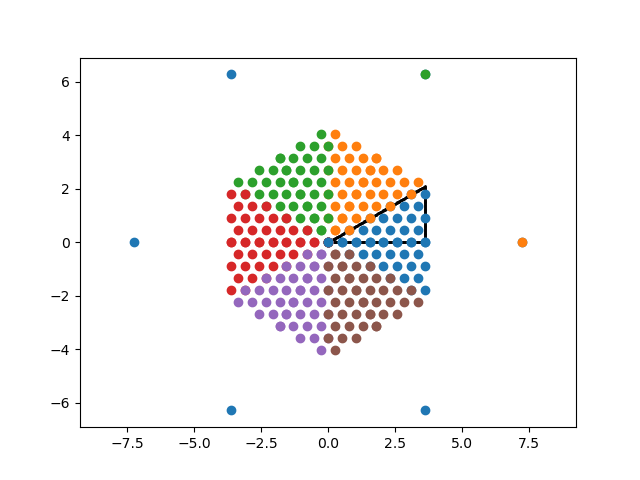

In [13]:
plt.figure()
plt.scatter(*get_coords(k_path.T), 1, c='k')

k_grid = get_coords(get_grid(7).T)

for i in range(6):
    plt.scatter(*(rot60(i)@k_grid), c=f"C{i}")
    plt.scatter(*(rot60(i)@mirrorX()@k_grid), c=f"C{i}")

plt.scatter(*np.array([get_coords(g(i)) for i in range(7)]).T)
plt.scatter(*get_coords(g(3)))
plt.scatter(*get_coords(g(4)))
plt.axis("equal")

# Irreducible Brillouin Zone (IBZ) Band Structure

In [14]:
g_basis = [g(i) for i in range(73)]

k_grid, weights = get_grid(101, get_weights=True)
bands = np.zeros((len(k_grid), len(g_basis)*4))
wfuns = np.zeros((len(k_grid), len(g_basis)*4, len(g_basis)*4), dtype=np.complex128)

for n, k in enumerate(tqdm(k_grid)):
    Hk = build_Hk(k, g_basis, theta=theta, mstar=mstar)
    eigh = np.linalg.eigh(Hk)
    bands[n] = eigh.eigenvalues
    wfuns[n] = eigh.eigenvectors

100%|███████████████████████████████████████| 3502/3502 [07:43<00:00,  7.55it/s]


In [15]:
interpolator = scipy.interpolate.LinearNDInterpolator(get_coords(k_grid.T).T, bands)

## DOS

In [16]:
# dos is 
# dn/dE (i.e. carrier density per energy, nm^-2 eV^-1)
# we have calculated the energy of a bunch of states
# so a weighted histogram tells us how many states there are between E and E+dE
# we need to normalize this => divide by total number of states in BZ
# now hist is d (n / ns) / d E

In [17]:
# First we calculate a very finely-spaced histogram for use in finding Fermi Surfaces at a particular filling factor
b_weights = np.tile(weights[...,np.newaxis], (1,bands.shape[1]))
fine_hist, fine_bin_edges = np.histogram(bands.flatten(), bins=100000, weights=2*b_weights.flatten()/np.sum(weights))
fine_nus = np.insert(np.cumsum(fine_hist[::-1]), 0, 0)[::-1]

Text(0.5, 0, '$\\nu$')

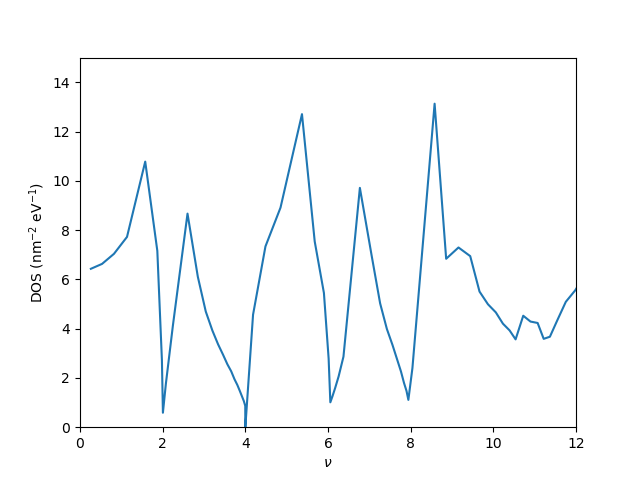

In [18]:
b_weights = np.tile(weights[...,np.newaxis], (1,bands.shape[1]))

hist, bin_edges = np.histogram(bands.flatten(), bins=2000, weights=2*b_weights.flatten()/np.sum(weights))
nus = np.cumsum(hist[::-1])[::-1]
theta_r = theta*np.pi/180
am = 3.28/theta_r
# hist *=
hist /= np.diff(bin_edges)[0]
hist /= np.sqrt(3)/2*(am/10)**2
hist *= 1000
plt.figure()
plt.plot(nus, hist)
plt.xlim(0, 12)
plt.ylim(0, 15)

# plt.axvline(1.65)
# plt.axvline(2)
# plt.axvline(2.63)
# plt.axvline(4)
# plt.axvline(5.33)
# plt.axvline(6)
# plt.axvline(7.32)
# plt.axvline(8)
# plt.axvline(9.15)

plt.ylabel(r"DOS (nm${}^{-2}$ eV${}^{-1}$)")
plt.xlabel(r"$\nu$")

(350.0, 400.0)

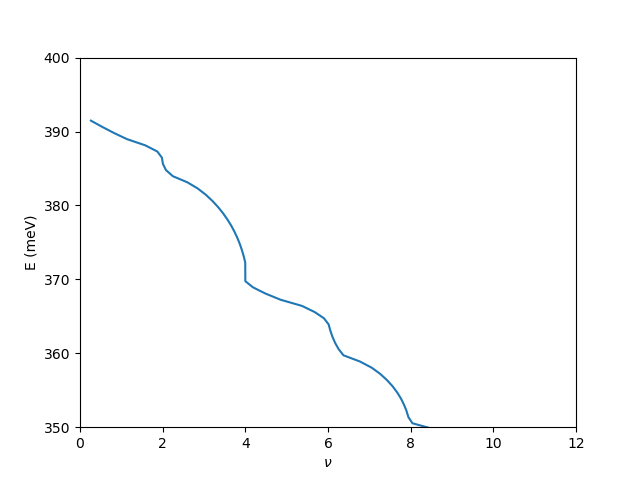

In [19]:
plt.figure()
plt.plot(nus, bin_edges[1:])
plt.xlabel(r"$\nu$")
plt.ylabel("E (meV)")
plt.xlim(0, 12)
plt.ylim(350, 400)

## FS Plotting

Here we plot the Fermi Surface by using skimage.measure.find_contours to find isolines (constant energy lines, i.e. FS pockets) of an array of the FS interpolated onto a fine rectangular k-grid.

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 74.85it/s]


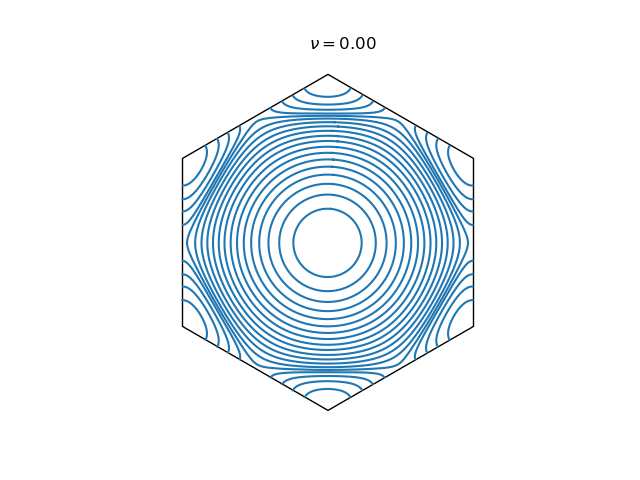

In [60]:
k_point = get_coords([1/3, 1/3])
N_x, N_y = 301, 351

kx_full, ky_full = np.meshgrid(
    np.linspace(-k_point[0], k_point[0], 2*N_x-1),
    np.linspace(-np.hypot(*k_point), np.hypot(*k_point), 2*N_y-1)
)
k_vec = np.moveaxis(np.array([kx_full, ky_full]), 0, 2)

#### This section of code transforms all points in the full BZ into the IBZ, where our interpolator is defined
mat_grid = (
    (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) >  np.pi/6)[...,np.newaxis,np.newaxis] * rot60(-1)
)

while not np.all(np.einsum("ijkk", mat_grid) == 2):
    k_vec = np.einsum(
        "ijkl,ijl->ijk",
        mat_grid,
        k_vec
    )
    # mat_grid rotates k_points into the BZ wedge centered on ky=0
    mat_grid = (
        (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
        (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) >  np.pi/6)[...,np.newaxis,np.newaxis] * rot60(-1)
    )

# mat_grid reflects k_points into the IBZ
mat_grid = (
    (np.arctan2(k_vec[...,1], k_vec[...,0]) >= 0)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    (np.arctan2(k_vec[...,1], k_vec[...,0]) < 0)[...,np.newaxis,np.newaxis] * mirrorX()
)
k_vec = np.einsum(
    "ijkl,ijl->ijk",
    mat_grid,
    k_vec
)
### done! now k_vec is in the IBZ, and we can interpolate the bands onto this finely spaced grid

interpolated_bands = interpolator(k_vec)

nu_ideal = np.linspace(0, 2, 21)
e_s = np.interp(nu_ideal, fine_nus[::-1], fine_bin_edges[::-1])

fig, ax = plt.subplots()

bz = matplotlib.patches.Polygon([rot60(i)@k_point for i in (0, 1, 2, 3, 4, 5, 0)], ec='k', fill=False, zorder=1)
ax.add_patch(bz)
ax.set_title(fr"$\nu = {nu_ideal[0]:.2f}$", horizontalalignment='left', x=0.462)

for e in tqdm(e_s):
    # for all (non-interpolated) bands within 1 meV of e_F
    band_ixs = np.where(np.min(np.abs(bands - e), axis=0) < 1)[0]
    # find the FS for that band and plot it
    for band_ix in band_ixs:
        contours = skimage.measure.find_contours(interpolated_bands[...,band_ix], e)
        # the contours are in pixel coordinates, so we have to translate to kx, ky
        for contour in contours:
            ax.plot(
                k_point[0]*(contour[:,1] - N_x)/N_x,
                np.hypot(*k_point)*(contour[:,0] - N_y)/N_y,
                c=f"C{bands.shape[1] - band_ix - 1}"
            )


plt.axis('equal')
plt.axis('off')
plt.show()

### FS Movie

100%|███████████████████████████████████████| 1401/1401 [00:32<00:00, 42.65it/s]


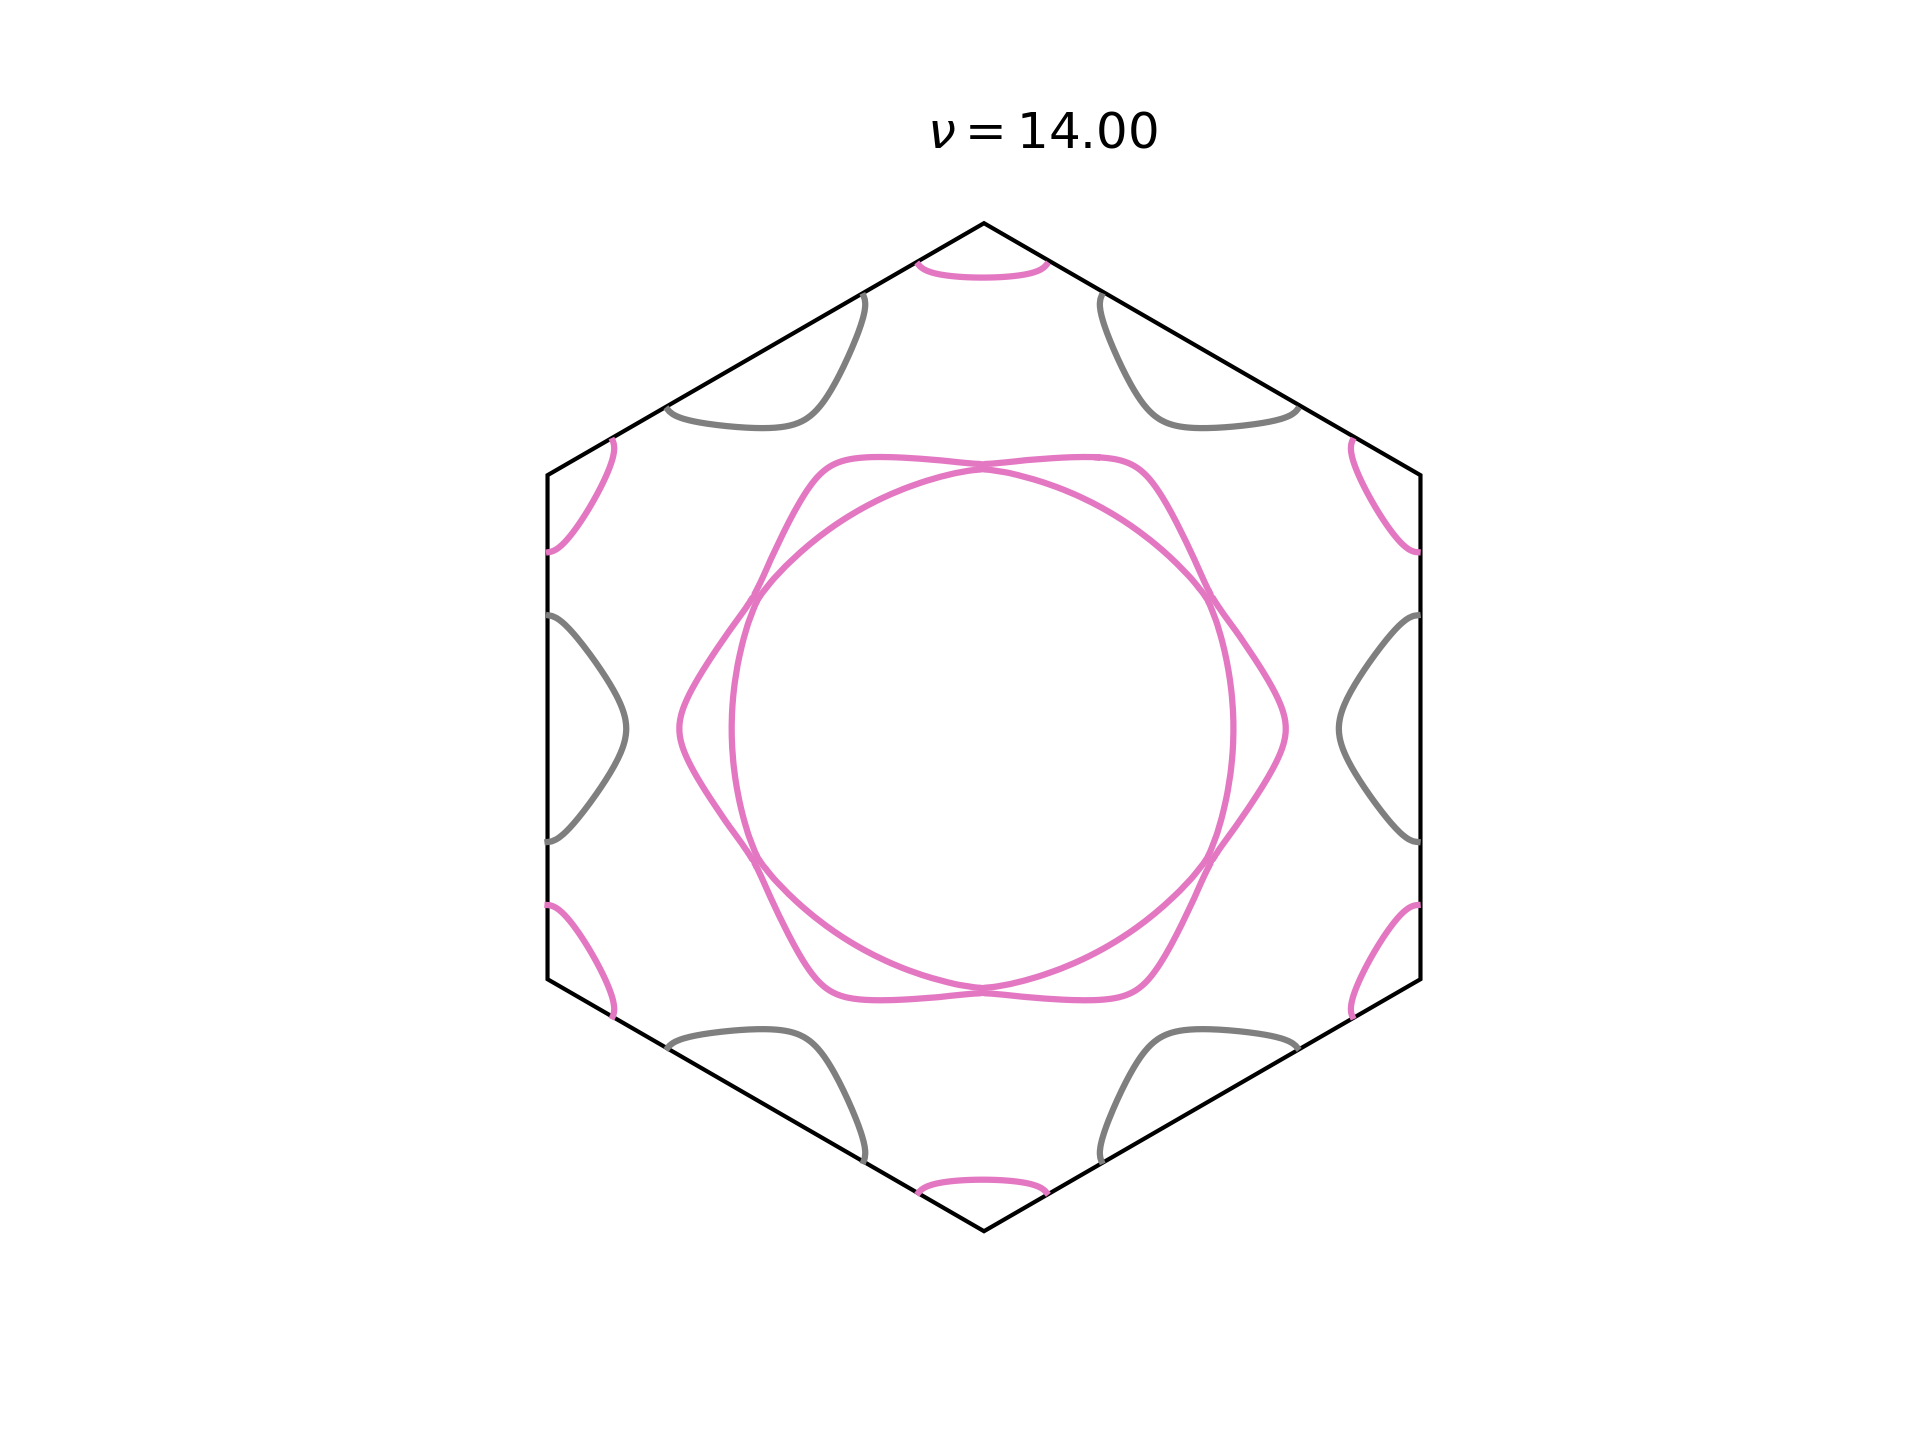

In [64]:
k_point = get_coords([1/3, 1/3])
N_x, N_y = 301, 351

kx_full, ky_full = np.meshgrid(
    np.linspace(-k_point[0], k_point[0], 2*N_x-1),
    np.linspace(-np.hypot(*k_point), np.hypot(*k_point), 2*N_y-1)
)
k_vec = np.moveaxis(np.array([kx_full, ky_full]), 0, 2)

#### This section of code transforms all points in the full BZ into the IBZ, where our interpolator is defined
mat_grid = (
    (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) >  np.pi/6)[...,np.newaxis,np.newaxis] * rot60(-1)
)

while not np.all(np.einsum("ijkk", mat_grid) == 2):
    k_vec = np.einsum(
        "ijkl,ijl->ijk",
        mat_grid,
        k_vec
    )
    # mat_grid rotates k_points into the BZ wedge centered on ky=0
    mat_grid = (
        (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
        (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) >  np.pi/6)[...,np.newaxis,np.newaxis] * rot60(-1)
    )

# mat_grid reflects k_points into the IBZ
mat_grid = (
    (np.arctan2(k_vec[...,1], k_vec[...,0]) >= 0)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    (np.arctan2(k_vec[...,1], k_vec[...,0]) < 0)[...,np.newaxis,np.newaxis] * mirrorX()
)
k_vec = np.einsum(
    "ijkl,ijl->ijk",
    mat_grid,
    k_vec
)
### done! now k_vec is in the IBZ, and we can interpolate the bands onto this finely spaced grid

interpolated_bands = interpolator(k_vec)

# nu_ideal = np.linspace(0, 14, 141) # 0.04 mins
nu_ideal = np.linspace(0, 14, 1401)
e_s = np.interp(nu_ideal, fine_nus[::-1], fine_bin_edges[::-1])


fig, ax = plt.subplots(dpi=300)
bz = matplotlib.patches.Polygon([rot60(i)@k_point for i in (0, 1, 2, 3, 4, 5, 0)], ec='k', fill=False, zorder=1)
ax.add_patch(bz)

# to make the movie, we pre-prepare some matplotlib.Line2D objects to use for the contours
lines = []
for i in range(6*30):
    lines.append(ax.plot([], [], c='k')[0])

title = ax.set_title(fr"$\nu = {nu_ideal[0]:.2f}$", horizontalalignment='left', x=0.462)

def update(frame):
    title.set_text(fr"$\nu = {nu_ideal[frame]:.2f}$")
    e = e_s[frame]
    
    # For each band within 1meV of e_F
    band_ixs = np.where(np.min(np.abs(bands - e), axis=0) < 1)[0]
    line_ix = 0
    for band_ix in band_ixs:
        # find and plot the FS contour
        contours = skimage.measure.find_contours(interpolated_bands[...,band_ix], e)
        for contour in contours:
            lines[line_ix].set_data(k_point[0]*(contour[:,1] - N_x)/N_x, np.hypot(*k_point)*(contour[:,0] - N_y)/N_y)
            # set the FS color to match the band color
            lines[line_ix].set_color(f"C{bands.shape[1] - band_ix - 1}")
            line_ix += 1
    # for any Line2D objects we don't use, make sure to make them not display
    while line_ix < len(lines):
        lines[line_ix].set_data([], [])
        line_ix += 1
    return lines

plt.axis('equal')
plt.axis('off')

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(nu_ideal), interval=50)
with tqdm(total=len(nu_ideal)) as t:
    ani.save(filename=f'FS3_fine_{theta:.2f}_deg_{mstar:.1f}me.mp4', writer='ffmpeg', progress_callback=lambda i, n: t.update())

### FS Movie with Bands

100%|███████████████████████████████████████| 1401/1401 [00:53<00:00, 26.36it/s]


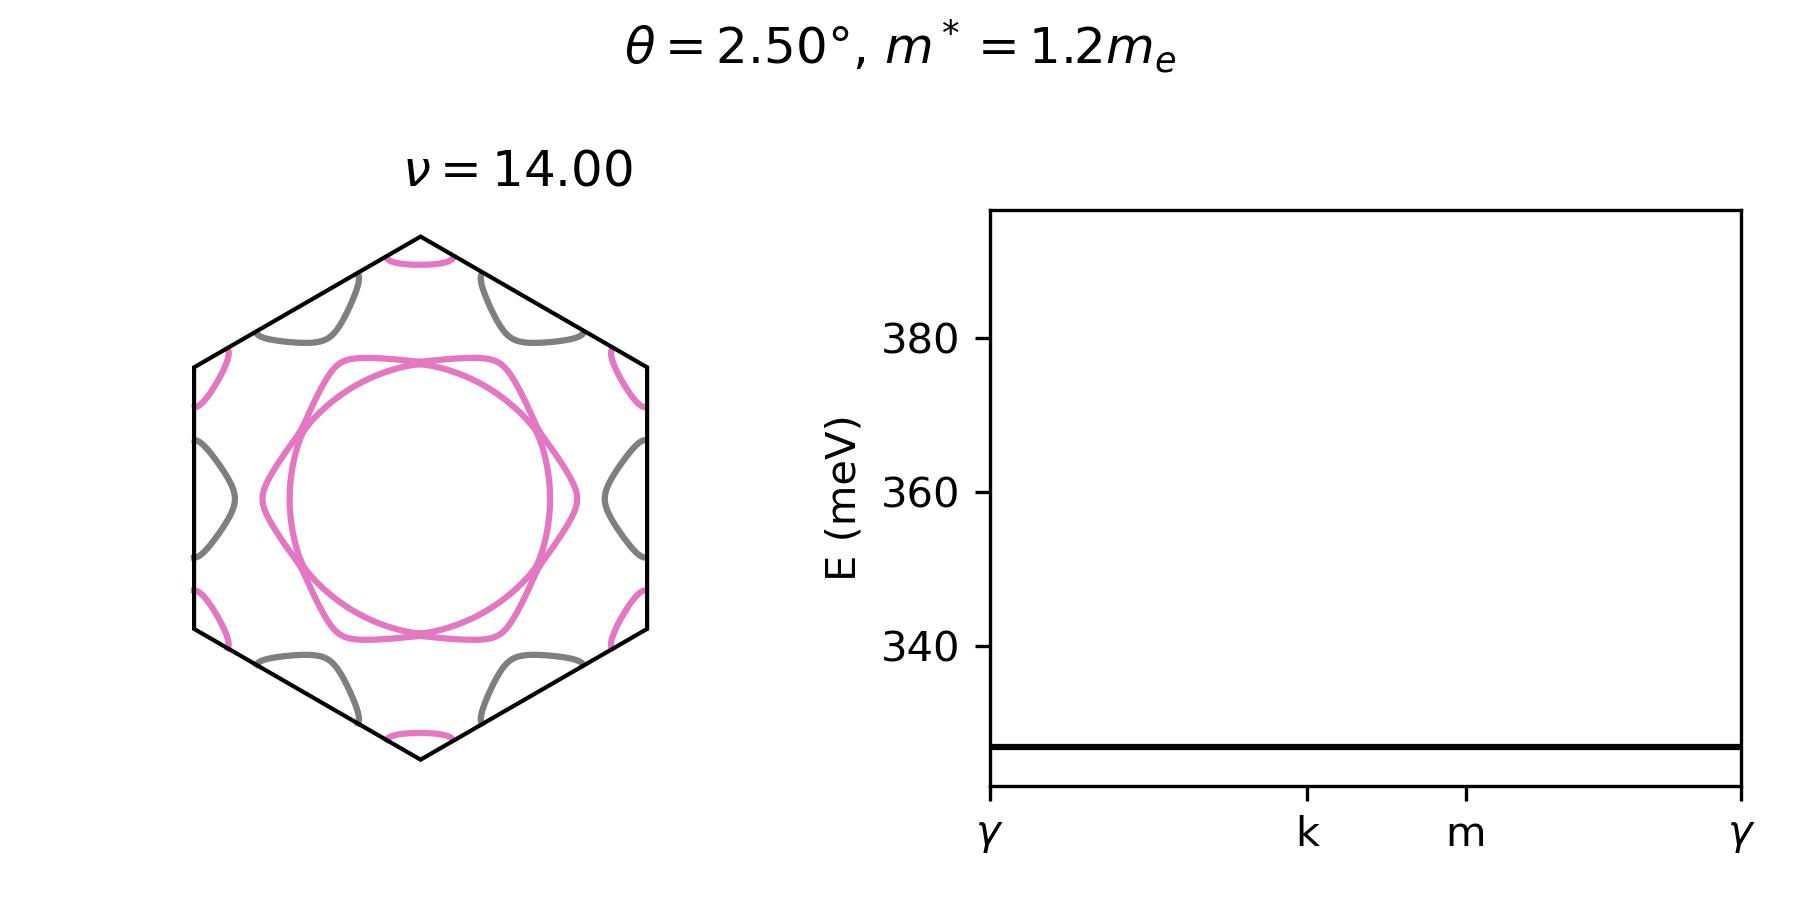

In [65]:
k_point = get_coords([1/3, 1/3])
N_x, N_y = 301, 351

kx_full, ky_full = np.meshgrid(
    np.linspace(-k_point[0], k_point[0], 2*N_x-1),
    np.linspace(-np.hypot(*k_point), np.hypot(*k_point), 2*N_y-1)
)
k_vec = np.moveaxis(np.array([kx_full, ky_full]), 0, 2)

#### This section of code transforms all points in the full BZ into the IBZ, where our interpolator is defined
mat_grid = (
    (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) >  np.pi/6)[...,np.newaxis,np.newaxis] * rot60(-1)
)

while not np.all(np.einsum("ijkk", mat_grid) == 2):
    k_vec = np.einsum(
        "ijkl,ijl->ijk",
        mat_grid,
        k_vec
    )
    # mat_grid rotates k_points into the BZ wedge centered on ky=0
    mat_grid = (
        (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
        (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) >  np.pi/6)[...,np.newaxis,np.newaxis] * rot60(-1)
    )

# mat_grid reflects k_points into the IBZ
mat_grid = (
    (np.arctan2(k_vec[...,1], k_vec[...,0]) >= 0)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    (np.arctan2(k_vec[...,1], k_vec[...,0]) < 0)[...,np.newaxis,np.newaxis] * mirrorX()
)
k_vec = np.einsum(
    "ijkl,ijl->ijk",
    mat_grid,
    k_vec
)
### done! now k_vec is in the IBZ, and we can interpolate the bands onto this finely spaced grid

interpolated_bands = interpolator(k_vec)

# nu_ideal = np.linspace(0, 14, 141)
nu_ideal = np.linspace(0, 14, 1401)
e_s = np.interp(nu_ideal, fine_nus[::-1], fine_bin_edges[::-1])


fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=300)
bz = matplotlib.patches.Polygon([rot60(i)@k_point for i in (0, 1, 2, 3, 4, 5, 0)], ec='k', fill=False, zorder=1)
ax[0].add_patch(bz)

lines = []
for i in range(6*30):
    lines.append(ax[0].plot([], [], zorder=0)[0])

for i in range(123,-1,-1):
    ax[1].plot(k_path_dist, gkmg_bands[:,i])

ax[1].set_ylim(e_s[-1] - 5, e_s[0] + 5)
ax[1].set_xlim(k_path_dist[0], k_path_dist[-1])
ax[1].set_ylabel("E (meV)")
ax[1].set_xticks([0, k_path_dist[points_g_k], k_path_dist[points_g_k+points_m_k], k_path_dist[-1]], [r"$\gamma$", "k", "m",r"$\gamma$"])
e_F = ax[1].axhline(e_s[0], c='k')

fig.suptitle(rf"$\theta={theta:.2f}\degree$, $m^* = {mstar:.1f} m_e$")
title = ax[0].set_title(fr"$\nu = {nu_ideal[0]:.2f}$", horizontalalignment='left', x=0.462)

def update(frame):
    title.set_text(fr"$\nu = {nu_ideal[frame]:.2f}$")
    e = e_s[frame]
    
    # For each band within 1meV of e_F
    band_ixs = np.where(np.min(np.abs(bands - e), axis=0) < 1)[0]
    line_ix = 0
    for band_ix in band_ixs:
        # find and plot the FS contour
        contours = skimage.measure.find_contours(interpolated_bands[...,band_ix], e)
        for contour in contours:
            lines[line_ix].set_data(k_point[0]*(contour[:,1] - N_x)/N_x, np.hypot(*k_point)*(contour[:,0] - N_y)/N_y)
            # set the FS color to match the band color
            lines[line_ix].set_color(f"C{bands.shape[1] - band_ix - 1}")
            line_ix += 1
    
    # for any Line2D objects we don't use, make sure to make them not display
    while line_ix < len(lines):
        lines[line_ix].set_data([], [])
        line_ix += 1
    e_F.set_ydata([e, e])
    return (*lines, e_F)

ax[0].set_aspect('equal')
ax[0].set_axis_off()
plt.tight_layout()

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(nu_ideal), interval=50)
with tqdm(total=len(nu_ideal)) as t:
    ani.save(filename=f'FS3_fine_with_BS_{theta:.2f}_deg_{mstar:.1f}me.mp4', writer='ffmpeg', progress_callback=lambda i,n: t.update())

# Deprecated Code

## FS Plot Attempt 1

Here the approach to finding the Fermi Surface is to use scipy.optimize.root to find intersections between the interpolated bands and the Fermi energy. Each point on the FS in the IBZ is then reflected and rotated to the full BZ. In one instance we find points on the FS for every k-point in the fine_grid, in the other instance we find 4 points on the FS using 4 k-points in the IBZ (to capture different pockets) and then "walk" along the FS.

In [223]:
R1 = rot60(1)
mX = mirrorX()
def fs_fn(x, e):
    ang = np.arctan2(x[1], x[0])
    while ang < -np.pi/6 or ang > np.pi/6:
        x = R1 @ x
        ang = np.arctan2(x[1], x[0])
    if ang < 0:
        x = mX @ x
    ix = np.argmin(np.abs(interpolator(x) - e))
    return [interpolator(x)[0,ix] - e, interpolator(x)[0,ix] - e]

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x13897a3c0>>
Traceback (most recent call last):
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1233, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/animation.py", line 1427, in _step
    still_going = super()._step(*args)
                  ^^^^^^^^^^^^^^^^^^^^
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/animation.py", line 1121, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/

588


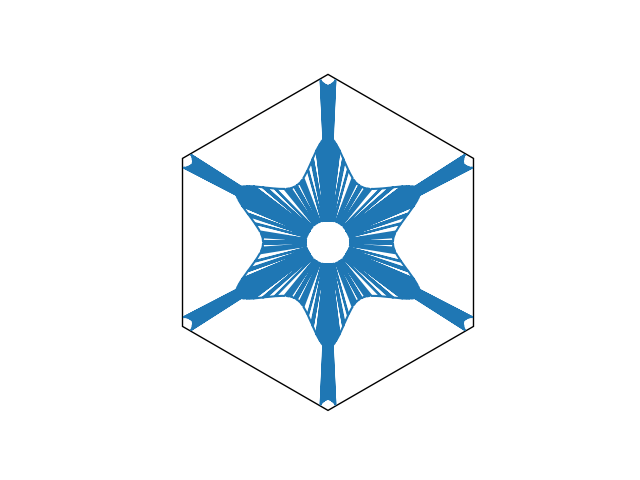

In [26]:
nu_ideal = np.linspace(0.2, 2.21, 11)
nu_ideal = [8.79]
e_s = np.interp(nu_ideal, nus[::-1], bin_edges[-1:0:-1])
plt.figure()
k_point = get_coords([1/3, 1/3])
bz = matplotlib.patches.Polygon([rot60(i)@k_point for i in (0, 1, 2, 3, 4, 5, 0)], ec='k', fill=False)
plt.gca().add_patch(bz)

for j, e in enumerate(e_s):
    fine_grid = get_grid(31)
    fs_list = [[], [], [], [], [], []]
    fs_list_m = [[], [], [], [], [], []]
    for k in fine_grid:
        try:
            res = scipy.optimize.root(fs_fn, x0=get_coords(k), args=e)
            if res.success:
                for i in range(6):
                    R = rot60(i)
                    fs_list[i].append(R@res.x)
                    fs_list_m[i].append(R@mirrorX()@res.x)
                    # plt.scatter(*R@res.x, 1, c=f"C{j}")
                    # plt.scatter(*R@np.array([res.x[0], -res.x[1]]), 1, c=f"C{j}")
        except:
            pass
    fs = np.concatenate([*fs_list, *fs_list_m]).T
    fs = fs[:,np.argsort(np.arctan2(*fs))]
    fs = np.append(fs, fs[:,0][...,np.newaxis], axis=1)

    # ID discontinuities
    gaps = np.hypot(*np.diff(fs))
    gap_mask = gaps > 0.16
    print(sum(gap_mask))
    # for ix in np.arange(len(gap_mask))[gap_mask][::-1]:
    #     fs = np.insert(fs, ix+1, np.nan, axis=1)
    
    plt.plot(*fs, c=f"C{j}")
    # for fs in fs_list_m:
    #     fs = np.array(fs).T
    #     fs = fs[:,np.argsort(np.arctan2(*fs))]
    #     plt.plot(*fs, c=f"C{j}")
    
plt.axis('equal')
plt.axis('off')
plt.show()

(-3.99035860131528, 3.9903586013152794, -4.607669225265029, 4.60766922526503)

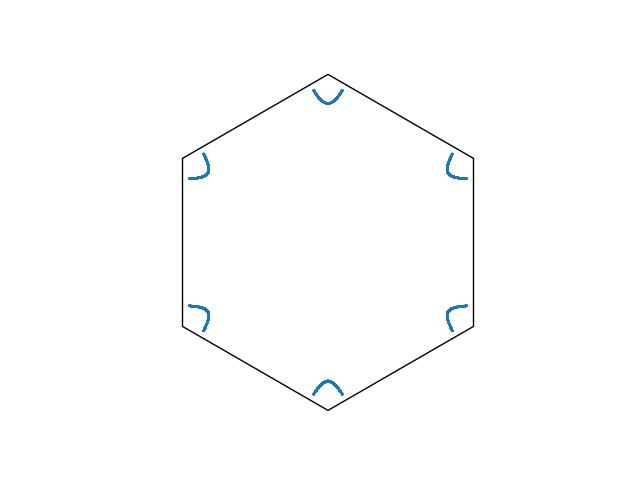

In [27]:
nu_ideal = np.linspace(0.2, 2.2, 11)
# nu_ideal = [8.9]
# nu_ideal = [15.5]
# nu_ideal = [1.3, 8.9, 15.5]
nu_ideal = [8]
e_s = np.interp(nu_ideal, nus[::-1], bin_edges[-1:0:-1])
plt.figure()
k_point = get_coords([1/3, 1/3])
bz = matplotlib.patches.Polygon([rot60(i)@k_point for i in (0, 1, 2, 3, 4, 5, 0)], ec='k', fill=False)
plt.gca().add_patch(bz)
# plt.scatter(*get_coords(k_path.T), 1, c='k')

for j, e in enumerate(e_s):
    fine_grid = get_grid(31)
    fs_list = [[], [], [], [], [], []]
    fs_list_m = [[], [], [], [], [], []]

    for k0_ix in (0, 100, 200, 300):
        k0 = fine_grid[k0_ix]
        counter = 0
        c = 0
        while c < 300:
            try:
                res = scipy.optimize.root(fs_fn, x0=get_coords(k0), args=e, options=dict(factor=1, diag=(1, 1), eps=0.01))
                if res.success:
                    
                    for i in range(6):
                        R = rot60(i)
                        fs_list[i].append(R@res.x)
                        fs_list_m[i].append(R@mirrorX()@res.x)
                        # plt.scatter(*R@res.x, 1, c=f"C{j}")
                        # plt.scatter(*R@np.array([res.x[0], -res.x[1]]), 1, c=f"C{j}")
                    if c == 0:
                        k0 = get_mn(res.x) + np.array([0.01, 0])
                    else:
                        khat = get_mn(fs_list[0][-1] - fs_list[0][-2])
                        khat /= np.hypot(*khat)
                        k0 = get_mn(res.x) + khat*0.01
                    c += 1
                    # print(c)
                else:
                    # k0 = k0 + np.array([0.01, 0])
                    k0_ix = (k0_ix + 1) % len(fine_grid)
                    k0 = fine_grid[k0_ix]
            except:
                # k0 = k0 + np.array([0.01, 0])
                k0_ix = (k0_ix + 1) % len(fine_grid)
                k0 = fine_grid[k0_ix]
            counter += 1
            # print(c, k0)
            if counter > 1000:
                break
    fs = np.concatenate([[*l, *list(reversed(l_m))] for l, l_m in zip(fs_list, fs_list_m)]).T
    # fs = np.concatenate([*fs_list, *fs_list_m]).T
    # fs = fs[:,np.argsort(np.arctan2(*fs))]
    # fs = np.append(fs, fs[:,0][...,np.newaxis], axis=1)

    if len(fs) > 0:
        # ID discontinuities
        gaps = np.hypot(*np.diff(fs))
        gap_mask = gaps > 0.1
        for ix in np.arange(len(gap_mask))[gap_mask][::-1]:
            fs = np.insert(fs, ix+1, np.nan, axis=1)
        
        plt.plot(*fs, c=f"C{j}")
        # plt.plot(*fs, c="gold")
        # for fs in fs_list_m:
        #     fs = np.array(fs).T
        #     fs = fs[:,np.argsort(np.arctan2(*fs))]
        #     plt.plot(*fs, c=f"C{j}")

plt.axis('equal')
plt.axis('off')

### Movie

/var/folders/vs/r6_f3ksd5p5fp4jrg6_mh0340000gn/T/ipykernel_16317/3114008617.py:45: RuntimeWarning: invalid value encountered in divide
  khat /= np.hypot(*khat)


15.19 mins


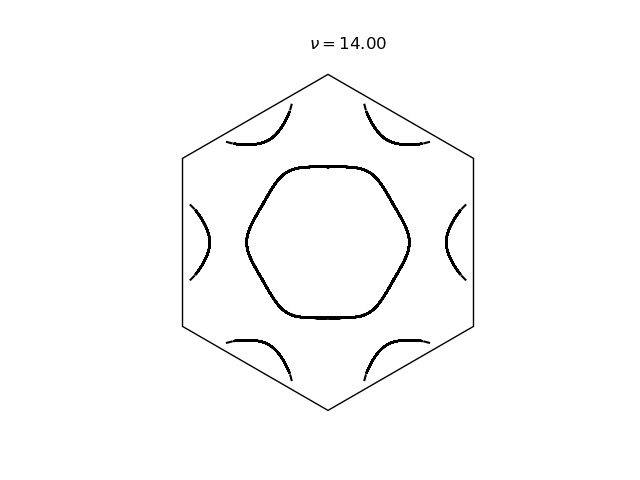

In [23]:
# nu_ideal = np.linspace(0, 14, 141) # 1.66 mins
# nu_ideal = np.linspace(0, 14, 11) # 0.12 mins
nu_ideal = np.linspace(0, 14, 1401) # 14.87 mins
# nu_ideal = [0.2, 8.5]

e_s = np.interp(nu_ideal, nus[::-1], bin_edges[-1:0:-1])

fig, ax = plt.subplots()

k_point = get_coords([1/3, 1/3])
bz = matplotlib.patches.Polygon([rot60(i)@k_point for i in (0, 1, 2, 3, 4, 5, 0)], ec='k', fill=False)
ax.add_patch(bz)
# plt.scatter(*get_coords(k_path.T), 1, c='k')
line, = ax.plot([0, 1], [0, 1], c='k')
fine_grid = get_grid(31)

mX = mirrorX()
Rs = [rot60(i) for i in range(6)]
title = ax.set_title(fr"$\nu = {nu_ideal[0]:.2f}$", horizontalalignment='left', x=0.462)

def update(frame):
    title.set_text(fr"$\nu = {nu_ideal[frame]:.2f}$")
    e = e_s[frame]
    fs_list = [[], [], [], [], [], []]
    fs_list_m = [[], [], [], [], [], []]

    for k0_ix in (0, 100, 250, -10):
        k0 = fine_grid[k0_ix]
        counter = 0
        c = 0
        while c < 300:
            try:
                res = scipy.optimize.root(fs_fn, x0=get_coords(k0), args=e, options=dict(factor=1, diag=(1, 1), eps=0.01))
                if res.success:
                    for i in range(6):
                        R = Rs[i]
                        fs_list[i].append(R@res.x)
                        fs_list_m[i].append(R@mX@res.x)
                        # plt.scatter(*R@res.x, 1, c=f"C{j}")
                        # plt.scatter(*R@np.array([res.x[0], -res.x[1]]), 1, c=f"C{j}")
                    if c == 0:
                        k0 = get_mn(res.x) + np.array([0.01, 0])
                    else:
                        khat = get_mn(fs_list[0][-1] - fs_list[0][-2])
                        khat /= np.hypot(*khat)
                        k0 = get_mn(res.x) + khat*0.01
                    c += 1
                    # print(c)
                else:
                    # k0 = k0 + np.array([0.01, 0])
                    k0_ix = (k0_ix + 1) % len(fine_grid)
                    k0 = fine_grid[k0_ix]
            except:
                # k0 = k0 + np.array([0.01, 0])
                k0_ix = (k0_ix + 1) % len(fine_grid)
                k0 = fine_grid[k0_ix]
            counter += 1
            # print(c, k0)
            if counter > 1000:
                break
    fs = np.concatenate([[*l, *list(reversed(l_m))] for l, l_m in zip(fs_list, fs_list_m)]).T
    # fs = np.concatenate([*fs_list, *fs_list_m]).T
    # fs = fs[:,np.argsort(np.arctan2(*fs))]
    # fs = np.append(fs, fs[:,0][...,np.newaxis], axis=1)
    
    if len(fs) > 0:
        # ID discontinuities
        gaps = np.hypot(*np.diff(fs))
        gap_mask = gaps > 0.1
        for ix in np.arange(len(gap_mask))[gap_mask][::-1]:
            fs = np.insert(fs, ix+1, np.nan, axis=1)

        line.set_data(*fs)
    else:
        line.set_data([], [])
        # plt.plot(*fs, c='k')
    return (line, )

plt.axis('equal')
plt.axis('off')

t0 = time.perf_counter()
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(nu_ideal), interval=50)
ani.save(filename='FS_fine.mp4', writer='ffmpeg')
tf = time.perf_counter()
print(f"{(tf-t0)/60:.2f} mins")

## FS Plot Attempt 2

Here the approach is to calculate something like the spectral function $A(\vec{k},\omega)$, using
$A(\vec{k},\omega) = \sum_n \exp(- \frac{(\varepsilon_{n,\vec{k}} - \omega)^2}{2 \sigma^2})$ where $\sigma$ describes the broadening of the bands. The pseudo-spectral function is computed in one quarter of the BZ, and then rotated/reflected to the full BZ.

tplotlib/animation.py", line 1431, in _step
    self._init_draw()
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/animation.py", line 1749, in _init_draw
    self._draw_frame(frame_data)
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/animation.py", line 1768, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/vs/r6_f3ksd5p5fp4jrg6_mh0340000gn/T/ipykernel_25629/2153367105.py", line 68, in update_frame
    title.set_text(fr"$\nu = {nu_ideal[frame]:.2f}$")
                              ~~~~~~~~^^^^^^^
TypeError: 'float' object is not subscriptable


(-3.62941252783267, 3.62941252783267, -4.190884599888784, 4.190884599888784)

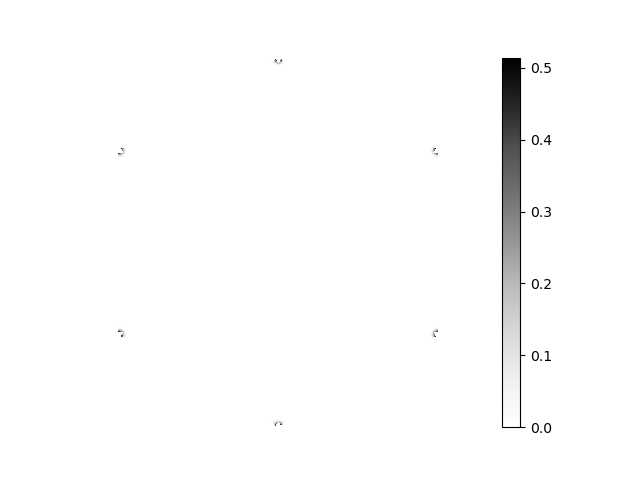

In [39]:
k_point = get_coords([1/3, 1/3])
kx, ky = np.meshgrid(
    np.linspace(0, k_point[0], 1001),
    np.linspace(0, np.hypot(*k_point), 1001)
)

k_vec = np.moveaxis(np.array([kx, ky]), 0, 2)

mat_grid = (
    (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    ((np.arctan2(k_vec[...,1], k_vec[...,0]) < -np.pi/6) | (np.arctan2(k_vec[...,1], k_vec[...,0]) > np.pi/6))[...,np.newaxis,np.newaxis] * rot60(-1)
)

while not np.all(np.einsum("ijkk", mat_grid) == 2):
    k_vec = np.einsum(
        "ijkl,ijl->ijk",
        mat_grid,
        k_vec
    )
    mat_grid = (
        (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
        ((np.arctan2(k_vec[...,1], k_vec[...,0]) < -np.pi/6) | (np.arctan2(k_vec[...,1], k_vec[...,0]) > np.pi/6))[...,np.newaxis,np.newaxis] * rot60(-1)
    )

mat_grid = (
    (np.arctan2(k_vec[...,1], k_vec[...,0]) >= 0)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    (np.arctan2(k_vec[...,1], k_vec[...,0]) < 0)[...,np.newaxis,np.newaxis] * mirrorX()
)
k_vec = np.einsum(
    "ijkl,ijl->ijk",
    mat_grid,
    k_vec
)

e = np.linspace(np.max(bands[:-1]), np.min(bands[:,-7]), 141)


nu_ideal = 4.2
e = np.interp(nu_ideal, nus[::-1], bin_edges[-1:0:-1])

width = 0.02
Ake = np.nansum(
    np.exp(-0.5*(interpolator(k_vec) - e)**2 / width**2)
    , axis=2
)

kx_full, ky_full = np.meshgrid(
    np.linspace(-k_point[0], k_point[0], 2001),
    np.linspace(-np.hypot(*k_point), np.hypot(*k_point), 2001)
)
Ake_full = np.zeros_like(kx_full)
Ake_full[1000:,1000:] = Ake
Ake_full[:1001,1000:] = Ake[::-1]
Ake_full[:1001,:1001] = Ake[::-1,::-1]
Ake_full[1000:,:1001] = Ake[:,::-1]

plt.figure()
plt.pcolormesh(kx_full, ky_full, Ake_full, cmap='Grays')
plt.axis('equal')
plt.axis('off')
# plt.show()

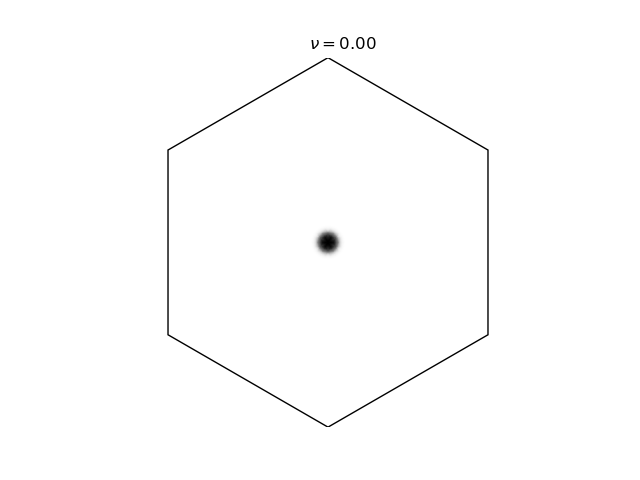

7.68 mins


ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x15f9ecd10>>
Traceback (most recent call last):
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/backend_bases.py", line 1233, in _on_timer
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/animation.py", line 1427, in _step
    still_going = super()._step(*args)
                  ^^^^^^^^^^^^^^^^^^^^
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/matplotlib/animation.py", line 1121, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/milan/miniforge3/envs/analysis/lib/python3.12/site-packages/

In [131]:
## Create k-grid
k_point = get_coords([1/3, 1/3])
# N_x, N_y = 1001, 1001
N_x, N_y = 1201, 1401
kx, ky = np.meshgrid(
    np.linspace(0, k_point[0], N_x),
    np.linspace(0, np.hypot(*k_point), N_y)
)
kx_full, ky_full = np.meshgrid(
    np.linspace(-k_point[0], k_point[0], 2*N_x-1),
    np.linspace(-np.hypot(*k_point), np.hypot(*k_point), 2*N_y-1)
)
Ak_full = np.zeros_like(kx_full)

k_vec = np.moveaxis(np.array([kx, ky]), 0, 2)
mat_grid = (
    (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    ((np.arctan2(k_vec[...,1], k_vec[...,0]) < -np.pi/6) | (np.arctan2(k_vec[...,1], k_vec[...,0]) > np.pi/6))[...,np.newaxis,np.newaxis] * rot60(-1)
)

while not np.all(np.einsum("ijkk", mat_grid) == 2):
    k_vec = np.einsum(
        "ijkl,ijl->ijk",
        mat_grid,
        k_vec
    )
    mat_grid = (
        (np.abs(np.arctan2(k_vec[...,1], k_vec[...,0])) <= np.pi/6)[...,np.newaxis,np.newaxis] * np.eye(2) + 
        ((np.arctan2(k_vec[...,1], k_vec[...,0]) < -np.pi/6) | (np.arctan2(k_vec[...,1], k_vec[...,0]) > np.pi/6))[...,np.newaxis,np.newaxis] * rot60(-1)
    )

mat_grid = (
    (np.arctan2(k_vec[...,1], k_vec[...,0]) >= 0)[...,np.newaxis,np.newaxis] * np.eye(2) + 
    (np.arctan2(k_vec[...,1], k_vec[...,0]) < 0)[...,np.newaxis,np.newaxis] * mirrorX()
)
k_vec = np.einsum(
    "ijkl,ijl->ijk",
    mat_grid,
    k_vec
)

nu_ideal = np.linspace(0, 14, 141) # 5.71 mins
# nu_ideal = np.linspace(0, 14, 11) # 0.67 mins
# nu_ideal = np.linspace(0, 14, 1401) # 14.87 mins

fig, ax = plt.subplots()

bz = matplotlib.patches.Polygon([rot60(i)@k_point for i in (0, 1, 2, 3, 4, 5, 0)], ec='k', fill=False, zorder=1)
ax.add_patch(bz)
title = ax.set_title(fr"$\nu = {nu_ideal[0]:.2f}$", horizontalalignment='left', x=0.462)

e_s = np.interp(nu_ideal, nus[::-1], bin_edges[-1:0:-1])

width = 0.025
Ak = np.nansum(
    np.exp(-0.5*(interpolator(k_vec) - e_s[0])**2 / width**2)
    , axis=2
)
Ak_full[N_y-1:,N_x-1:] = Ak
Ak_full[:N_y,N_x-1:] = Ak[::-1]
Ak_full[:N_y,:N_x] = Ak[::-1,::-1]
Ak_full[N_y-1:,:N_x] = Ak[:,::-1]

im = ax.pcolormesh(kx_full, ky_full, Ak_full, cmap='Grays',zorder=0)

interpolated_bands = interpolator(k_vec)

def update_frame(frame):
    title.set_text(fr"$\nu = {nu_ideal[frame]:.2f}$")
    e = e_s[frame]
    Ak = np.nansum(
        np.exp(-0.5*(interpolated_bands - e)**2 / width**2)
        , axis=2
    )
    Ak_full[N_y-1:,N_x-1:] = Ak
    Ak_full[:N_y,N_x-1:] = Ak[::-1]
    Ak_full[:N_y,:N_x] = Ak[::-1,::-1]
    Ak_full[N_y-1:,:N_x] = Ak[:,::-1]
    im.set_array(Ak_full)
    return (im,)


plt.axis('equal')
plt.axis('off')
plt.show()

t0 = time.perf_counter()
ani = animation.FuncAnimation(fig=fig, func=update_frame, frames=len(nu_ideal), interval=50)
ani.save(filename='FS2.mp4', writer='ffmpeg')
tf = time.perf_counter()
print(f"{(tf-t0)/60:.2f} mins")

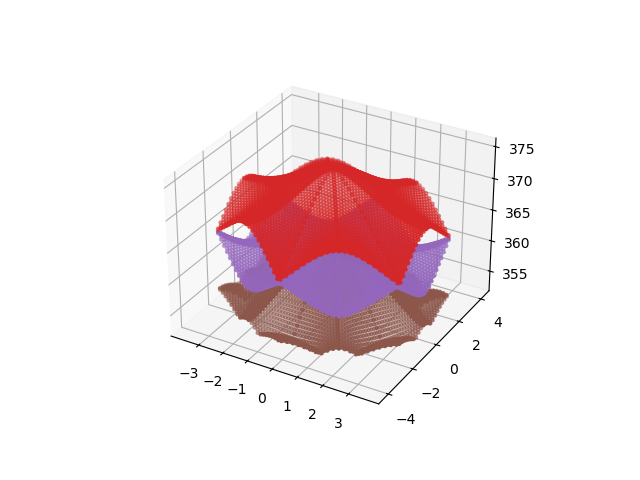

In [210]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for i in range(4,7):
    for j in range(6):
        ax.scatter(
            *(rot60(j)@get_coords(k_grid.T)),
            bands[:,-i],
            s=5,
            c=f"C{i-1}"
        )
        ax.scatter(
            *(rot60(j)@mirrorX()@get_coords(k_grid.T)),
            bands[:,-i],
            s=5,
            c=f"C{i-1}"
        )